# Проект: Выбор локации для скважины

**Описание исседования** <br>
Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль, и проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных** <br>
Предоставлены пробы нефти в трёх регионах

***Признаки***

*id* — уникальный идентификатор скважины;<br>
*f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);<br>

***Целевой признак***

*product* — объём запасов в скважине (тыс. баррелей).<br>

***Условия задачи:***

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Содержание**

 [Шаг 1. Загрузка и подготовка данныx](#step1)
 
 [Шаг 2. Обучение и проверка модели ](#step2)
 
 [Шаг 3. Подготовка к расчету прибыли](#step3)
 
 [Шаг 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели](#step4)
 
 [Шаг 5. Риски и прибыль для каждого региона](#step5)
 
 [Общий вывод](#step6)

<a id = 'step1'></a>
# Шаг 1. Загрузка и подготовка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as st
import os
import pandas_profiling

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [170]:
#функция для считывания файла
def read(data):
    if os.path.exists(data):
        return pd.read_csv(data)
    else:
        return pd.read_csv(f'/datasets/{data}')

In [171]:
region_0 = read('geo_data_0.csv')
region_1 = read('geo_data_1.csv')
region_2 = read('geo_data_2.csv')

In [173]:
#profile = region_0.profile_report(title='Pandas Profiling Report', progress_bar=False)

In [177]:
regions = {'Region_0':region_0,'Region_1':region_1,'Region_2':region_2}

Region_0
---------------------------------------------------------------------------------------------------
Пропуски:  0
Дубликаты:  0



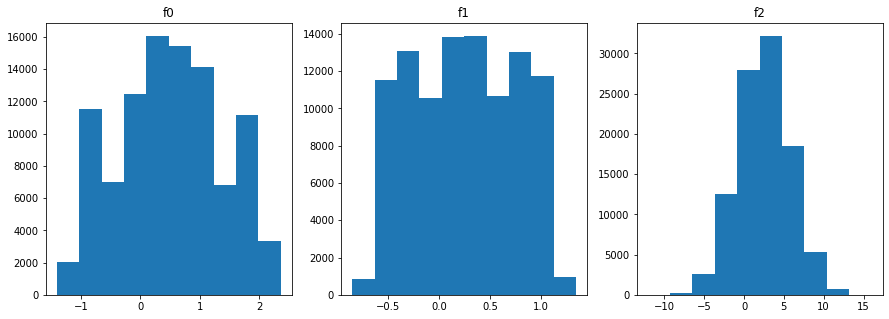

Region_1
---------------------------------------------------------------------------------------------------
Пропуски:  0
Дубликаты:  0



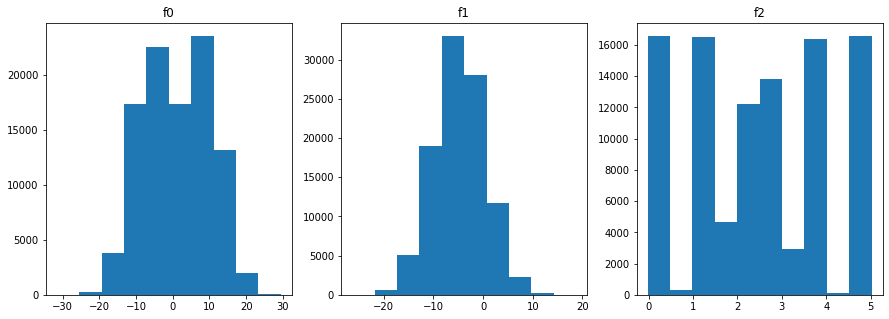

Region_2
---------------------------------------------------------------------------------------------------
Пропуски:  0
Дубликаты:  0



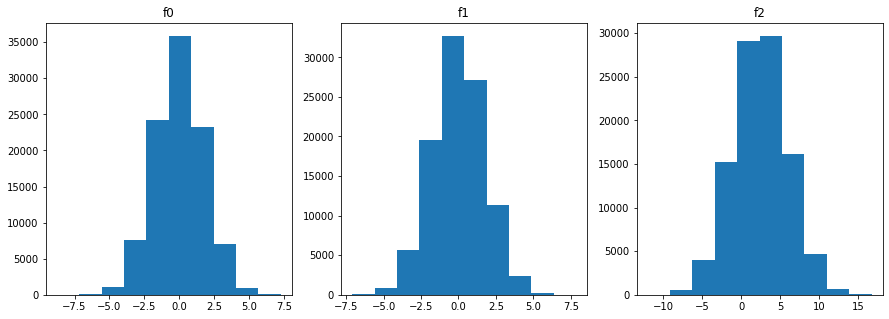

In [149]:
#проверяем на наличие пропусков и дубликатов
#смотрим распределение признаков
#удаляем ненужный столбец в данных

for k,v in regions.items():
    print(k)
    print('---------------------------------------------------------------------------------------------------')
    print('Пропуски: ',v.isna().sum().sum())
    duble = v.duplicated().sum()
    print('Дубликаты: ',duble)
    print()
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
    for axes, column in zip(axes.flat, regions[k].loc[:,'f0':'f2'].columns):
        axes.hist(regions[k][column])
        axes.set(title = column)
    plt.show()  
    if duble == 0:
        v.drop(['id'],axis=1,inplace=True)

<a id = 'step2'></a>
# Шаг 2.  Обучение и проверка модели 

In [161]:
#функция которая:
   #2.1 Разбивает данные на обучающую и валидационную выборки в соотношении 75:25
   #2.2 Обучает модель и делает предсказания на валидационной выборке
   #2.3 Сохраняет предсказания и правильные ответы на валидационной выборке
   #2.4 Печатает на экране средний запас предсказанного сырья и RMSE модели

def predicted_product(region):
    #2.1
    #выделяем признаки и целевой признак 
    features = region.drop('product', axis = 1)
    target = region['product']

    #разобъем получившуюся выборку 
    features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size = 0.25, 
                                                                                  random_state = 12345)
    
    ##масштабирование признаков

    numeric = ['f0','f1','f2'] #список численных признаков

    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    pd.options.mode.chained_assignment = None

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    #2.2
    model = LinearRegression()

    model.fit(features_train,target_train) 
    predicted_valid = pd.Series(model.predict(features_valid))
    rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
    
    #2.3
    df = pd.DataFrame(data = {'target_valid': target_valid.reset_index(drop = True), 'prediction': predicted_valid})
    #2.4
    average = predicted_valid.sum()/len(predicted_valid)
    print('--------------------------')
    print('Average product = {:.3f}'.format(average))
    print('RMSE = {:.3f}'.format(rmse))
    print()
    return df, average

In [162]:
print('Region_0')
predictions_0, av_0  = predicted_product(regions['Region_0'])
print('Region_1')
predictions_1, av_1 = predicted_product(regions['Region_1'])
print('Region_2')
predictions_2,av_2 = predicted_product(regions['Region_2'])

all_predictions = [predictions_0,predictions_1,predictions_2]

Region_0
--------------------------
Average product = 92.593
RMSE = 37.579

Region_1
--------------------------
Average product = 68.729
RMSE = 0.893

Region_2
--------------------------
Average product = 94.965
RMSE = 40.030



<a id = 'step3'></a>
# Шаг 3.   Подготовка к расчету прибыли

* Достаточный объём сырья для безубыточной разработки новой скважины

In [163]:
product_enough = 10**10/450000
print('Достаточный объём сырья - {:.2f} тыс.баррелей'.format(product_enough))

Достаточный объём сырья - 22222.22 тыс.баррелей


* Сравниваем полученный объём сырья со средним запасом в каждом регионе

In [164]:
print("Средний объем нефти в скважине для безубыточного функционирования - {:.2f} тыс.баррелей ".format(product_enough/200))

Средний объем нефти в скважине для безубыточного функционирования - 111.11 тыс.баррелей 


<div class="alert alert-block alert-info">
    
**Комментарий студента** 

Запас сырья в скважинах меньше cреднего объема нефти в скважине для безубыточного функционирования.

<a id = 'step4'></a>
# Шаг 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [165]:
income_per_barrel = 450 * 10**3 
budget = 10**10 

def profit(predictions,target): 
    #4.1 Выбераем скважины с максимальными значениями предсказаний
    #4.2. Суммируем целевое значение объёма сырья, соответствующее этим предсказаниям
    #4.3. Рассчитываем прибыль для полученного объёма сырья
    
    top_pred = predictions.sort_values(ascending=False)
    top_target = target[top_pred.index][:200]
    revenue = top_target.sum() * income_per_barrel
    return revenue - budget

<a id = 'step5'></a>
# Шаг 5. Риски и прибыль для каждого региона

Посчитайте риски и прибыль для каждого региона:
5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [166]:
def risks_and_revenue(predictions):
    state = np.random.RandomState(12345)
    rev= []
    
    #5.1 Bootstrap
    for i in range(1000):
        target_sample = predictions['target_valid'].sample(500, replace=True, random_state=state)
        predictions_sample = predictions['prediction'][target_sample.index]
        rev.append(profit(predictions_sample, target_sample))
        
    rev = pd.Series(rev)
    
    #5.2
    mean = rev.mean()
    lower = rev.quantile(0.025) 
    upper = rev.quantile(0.975) 
    #confidence_interval = st.t.interval(0.95, len(rev)-1, rev.mean(), rev.sem())
    risk = (rev<0).sum()/len(rev) 
    
    print('Средняя прибыль: {:.2f} р'.format(mean))
    print('95%-й доверительный интервал:', '(',lower,':',upper,')')
    print('Риск убытков {:.1%}: '.format(risk))

In [167]:
for k, predictions in zip(regions.keys(), all_predictions):
    print(k)
    risks_and_revenue(predictions)
    print()
    

Region_0
Средняя прибыль: 425938526.91 р
95%-й доверительный интервал: ( -102090094.83793654 : 947976353.3583689 )
Риск убытков 6.0%: 

Region_1
Средняя прибыль: 515222773.44 р
95%-й доверительный интервал: ( 68873225.37050176 : 931547591.2570494 )
Риск убытков 1.0%: 

Region_2
Средняя прибыль: 435008362.78 р
95%-й доверительный интервал: ( -128880547.32978901 : 969706954.1802661 )
Риск убытков 6.4%: 



<a id = 'step6'></a>

<div class="alert alert-block alert-info">
    
<h2> Общий вывод <a class="tocSkip"></h2>
    
В данной работе было необходимо изучить данные о добычи сырья с целью построения модели для определения наиболее пепрспективного региона разработки нефтевого месторождения.

Для этого мы загрузили и подготовили данные и построили линейную модель для предсказания объемов нефти в скважинах по каждому региону. Также мы рассчитали средний объем запаса сырья в скважине в каждом регионе, который оказался ниже cреднего объема нефти в скважине для безубыточного функционирования. По итогу сравнения можно сделать вывод, что разработка месторождений в каждом из рассматривамых регионов будет убыточной.
    
Далее, применяя технику Bootstrap, мы нашли 95% доверительный интервал для среднего объема нефти в скважинах и посчитали риски и прибыль для каждого региона. По итогу было выяснено, что наиболее перспективным для разработки представляется регион № 2, т.к. риски убытков наименьшие, а средняя прибыль наибольшая.

</div>